# GPT-2 Lyrics Generation Service

This notebook implements the end-to-end pipeline that powers Musify's lyric generator. It covers data acquisition, exploratory analysis, GPT-2 fine-tuning, inference utilities, and model export so the trained artifacts can be consumed by `backend/services/lyrics_service.py`.


---

## 1. Environment Setup and Dependency Installation

Install and verify the full inference and training stack:

- `transformers`, `torch`, `accelerate` for GPT-2 modeling and hardware acceleration.
- `pandas`, `numpy`, `matplotlib`, `seaborn`, `wordcloud` for preprocessing and EDA.
- `kagglehub` (or Kaggle CLI) for automated dataset retrieval.
- `tqdm`, `datasets`, and helper utilities referenced later in the notebook.

Each installation cell also prints library versions so experiments remain reproducible.


In [10]:
# Install dependency packages
!pip install transformers torch numpy pandas tqdm kagglehub accelerate -q
print("✓ All dependencies installed")

✓ All dependencies installed


In [11]:
# ============================================================================
# Import Libraries
# ============================================================================
import os
import json
import re
import random
from pathlib import Path
from typing import Optional, Dict, List

import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
from transformers import (
    GPT2LMHeadModel,
    GPT2Tokenizer,
    GPT2Config,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling,
    set_seed
)
from torch.utils.data import Dataset

print("✓ Imports completed")

✓ Imports completed


In [12]:
# ============================================================================
# Configuration Parameters
# ============================================================================
CONFIG = {
    # Random seed
    'seed': 42,
    
    # Data configuration
    'min_length': 50,           # Minimum lyrics length
    'max_songs': 5000,          # Maximum number of songs
    'train_split': 0.9,         # Training set ratio
    
    # Model configuration
    'model_name': 'gpt2',       # 'gpt2', 'gpt2-medium', 'gpt2-large'
    'max_length': 512,          # Maximum sequence length
    
    # Training configuration (if fine-tuning)
    'do_fine_tune': True,       # CHANGED: Set to True to enable fine-tuning
    'num_epochs': 3,
    'batch_size': 4,
    'learning_rate': 5e-5,
    'warmup_steps': 500,
    'save_steps': 1000,
    
    # Generation configuration
    'temperature': 0.9,       # Increased for creativity
    'top_k': 50,
    'top_p': 0.95,
    'repetition_penalty': 1.2, # Increased to prevent loops
    'max_new_tokens': 400,    # Increased for longer lyrics
    'min_new_tokens': 100,    # Minimum length enforcement
    
    # Path configuration
    'output_dir': '../models/gpt2_lyrics',
    'cache_dir': '../.cache',
}

# Set random seed
set_seed(CONFIG['seed'])
random.seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])
torch.manual_seed(CONFIG['seed'])

# Set device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✓ Using device: {DEVICE}")
if DEVICE.type == 'cuda':
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    print(f"  VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

# Print configuration
print("\nConfiguration Parameters:")
print("-" * 60)
for key, value in CONFIG.items():
    print(f"  {key:20s}: {value}")

✓ Using device: cuda
  GPU: NVIDIA GeForce RTX 4060 Laptop GPU
  VRAM: 8.6 GB

Configuration Parameters:
------------------------------------------------------------
  seed                : 42
  min_length          : 50
  max_songs           : 5000
  train_split         : 0.9
  model_name          : gpt2
  max_length          : 512
  do_fine_tune        : True
  num_epochs          : 3
  batch_size          : 4
  learning_rate       : 5e-05
  warmup_steps        : 500
  save_steps          : 1000
  temperature         : 0.9
  top_k               : 50
  top_p               : 0.95
  repetition_penalty  : 1.2
  max_new_tokens      : 400
  min_new_tokens      : 100
  output_dir          : ../models/gpt2_lyrics
  cache_dir           : ../.cache


---

## 2. Dataset Preparation

1. **Acquisition** - Downloads the Kaggle lyrics corpus and extracts it into a structured `data/` directory.
2. **Cleaning** - Drops duplicates, strips markup, normalizes whitespace, and filters samples by configurable character or word length bounds.
3. **Metadata tagging** - Adds optional columns (genre, mood, era) to support conditional prompts during generation.
4. **Caching** - Persists the processed dataset so repeated runs skip expensive preprocessing.


In [13]:
# ============================================================================
# Download Dataset
# ============================================================================
import kagglehub

# Download latest version
path = kagglehub.dataset_download("notshrirang/spotify-million-song-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\KrabbyPatty\.cache\kagglehub\datasets\notshrirang\spotify-million-song-dataset\versions\1


In [14]:
# ============================================================================
# Load Lyrics Data
# ============================================================================
def find_and_load_lyrics(root_path):
    """Load lyrics dataset"""
    root_path = Path(root_path)
    
    csv_files = list(root_path.rglob('*.csv'))
    json_files = list(root_path.rglob('*.json'))
    txt_files = list(root_path.rglob('*.txt'))
    
    print(f"Found files: {len(csv_files)} CSV, {len(json_files)} JSON, {len(txt_files)} TXT")
    
    # Try CSV first
    for csv_file in csv_files:
        try:
            df = pd.read_csv(csv_file, encoding='utf-8', on_bad_lines='skip')
            
            possible_cols = ['lyrics', 'lyric', 'text', 'song', 'content', 'Lyrics', 'LYRICS']
            lyric_col = next((c for c in possible_cols if c in df.columns), None)
            
            if lyric_col:
                print(f"✓ Loaded CSV: {csv_file.name}")
                print(f"  Columns: {list(df.columns)}")
                print(f"  Using column: {lyric_col}")
                return df[lyric_col].dropna().tolist()
        except Exception as e:
            print(f"✗ Failed to load {csv_file.name}: {e}")
    
    # Try JSON
    for json_file in json_files:
        try:
            with open(json_file, 'r', encoding='utf-8') as f:
                data = json.load(f)
            
            if isinstance(data, list):
                lyrics = []
                for item in data:
                    if isinstance(item, dict):
                        for key in ['lyrics', 'lyric', 'text']:
                            if key in item:
                                lyrics.append(item[key])
                                break
                
                if lyrics:
                    print(f"✓ Loaded JSON: {json_file.name}")
                    return lyrics
        except Exception as e:
            print(f"✗ Failed to load {json_file.name}: {e}")

    # Try TXT (Added support for poetry dataset)
    if txt_files:
        print(f"Processing {len(txt_files)} TXT files...")
        lyrics = []
        for txt_file in tqdm(txt_files, desc="Reading TXT files"):
            try:
                with open(txt_file, 'r', encoding='utf-8') as f:
                    content = f.read().strip()
                    if content:
                        lyrics.append(content)
            except Exception as e:
                continue
        
        if lyrics:
            print(f"✓ Loaded {len(lyrics)} lyrics from TXT files")
            return lyrics
    
    raise ValueError("No valid lyrics data found")


lyrics_list = find_and_load_lyrics(path)
print(f"\n✓ Total lyrics loaded: {len(lyrics_list):,}")

Found files: 1 CSV, 0 JSON, 0 TXT
✓ Loaded CSV: spotify_millsongdata.csv
  Columns: ['artist', 'song', 'link', 'text']
  Using column: text

✓ Total lyrics loaded: 57,650


In [15]:
# ============================================================================
# Data Cleaning
# ============================================================================
def clean_lyrics(lyrics_list, min_length=50):
    """Clean lyrics data with enhanced filtering"""
    cleaned = []
    seen = set()
    
    # Patterns to remove (metadata, instructions, headers)
    remove_patterns = [
        r'\[.*?\]',              # Remove [Chorus], [Verse 1], etc.
        r'\(.*?\)',              # Remove (backing vocals), (repeat), etc.
        r'^Track \d+.*$',        # Remove "Track 1: Title" lines
        r'^Album:.*$',           # Remove Album info
        r'^Written by:.*$',      # Remove credits
        r'Repeat Chorus.*',      # Remove instructions
        r'Instrumental',         # Remove instrumental markers
        r'Chorus:',              # Remove explicit headers
        r'Verse \d+:',           # Remove verse headers
        r'http\S+',              # Remove URLs
        r'externalToEVA',        # Remove specific artifact found in dataset
    ]
    
    print("Cleaning data...")
    for lyric in tqdm(lyrics_list):
        # Skip empty values
        if not lyric or not isinstance(lyric, str):
            continue
        
        lyric = str(lyric).strip()
        
        # 1. Remove specific metadata patterns
        for pattern in remove_patterns:
            lyric = re.sub(pattern, '', lyric, flags=re.IGNORECASE | re.MULTILINE)
        
        # 2. Clean special characters (keep basic punctuation)
        # Force ASCII to remove unicode artifacts like ÃÂÃÂ
        lyric = lyric.encode('ascii', 'ignore').decode('ascii')
        lyric = re.sub(r'[^a-zA-Z0-9\s.,!?\'\"\-;:\n]', ' ', lyric)
        
        # 3. Normalize whitespace
        lyric = re.sub(r' +', ' ', lyric)           # Multiple spaces -> single space
        lyric = re.sub(r'\n{3,}', '\n\n', lyric)    # Multiple newlines -> double newline
        lyric = lyric.strip()
        
        # 4. Quality checks
        if len(lyric) < min_length:
            continue
            
        # Skip if too much repetition (garbage detection)
        if len(set(lyric.split())) < 5: # Too few unique words
            continue
            
        # Skip duplicates
        if lyric in seen:
            continue
        seen.add(lyric)
        
        cleaned.append(lyric)
    
    return cleaned


# Execute cleaning
cleaned_lyrics = clean_lyrics(lyrics_list, min_length=CONFIG['min_length'])

# Limit dataset size
if len(cleaned_lyrics) > CONFIG['max_songs']:
    print(f"\nLimiting dataset to {CONFIG['max_songs']:,} songs")
    cleaned_lyrics = cleaned_lyrics[:CONFIG['max_songs']]

print(f"\nCleaning Statistics:")
print(f"  Original count: {len(lyrics_list):,}")
print(f"  Cleaned count: {len(cleaned_lyrics):,}")
print(f"  Removed count: {len(lyrics_list) - len(cleaned_lyrics):,}")

Cleaning data...


100%|██████████| 57650/57650 [00:12<00:00, 4614.35it/s]


Limiting dataset to 5,000 songs

Cleaning Statistics:
  Original count: 57,650
  Cleaned count: 5,000
  Removed count: 52,650


In [16]:
# ============================================================================
# Preview Sample
# ============================================================================
print("\nSample Preview:")
print("=" * 80)
sample_idx = random.randint(0, len(cleaned_lyrics) - 1)
sample = cleaned_lyrics[sample_idx]
preview = sample[:300] + "..." if len(sample) > 300 else sample
print(preview)
print("=" * 80)


Sample Preview:
I'm not afraid of anything, 
I just need to know that I can breathe 
And I don't need much of anything 
But suddenly suddenly 
 
I am small and the world is big 
All around me is fast moving 
Surrounded by so many things 
Suddenly suddenly, 
 
 
How does it feel to be 
Different from me ...


---

## 3. Exploratory Data Analysis

- Token and word distribution plots highlight the sequence lengths required for GPT-2 context windows.
- Word clouds and frequency tables reveal dominant themes and vocabulary.
- Optional genre or mood breakdowns verify dataset balance before fine-tuning.

Use these diagnostics to choose prompt templates, truncation lengths, and sampling strategies.


In [17]:
# ============================================================================
# Install Additional Libraries for EDA
# ============================================================================
try:
    import matplotlib.pyplot as plt
    from collections import Counter
    from wordcloud import WordCloud
    import seaborn as sns
    print("✓ EDA libraries available")
except ImportError:
    print("Installing wordcloud...")
    import subprocess
    subprocess.check_call(["pip", "install", "wordcloud", "seaborn", "-q"])
    import matplotlib.pyplot as plt
    from collections import Counter
    from wordcloud import WordCloud
    import seaborn as sns
    print("✓ EDA libraries installed")

# ============================================================================
# Create Output Directory
# ============================================================================
output_dir = '../output'
os.makedirs(output_dir, exist_ok=True)
print(f"✓ Output directory ready: {output_dir}")


✓ EDA libraries available
✓ Output directory ready: ../output


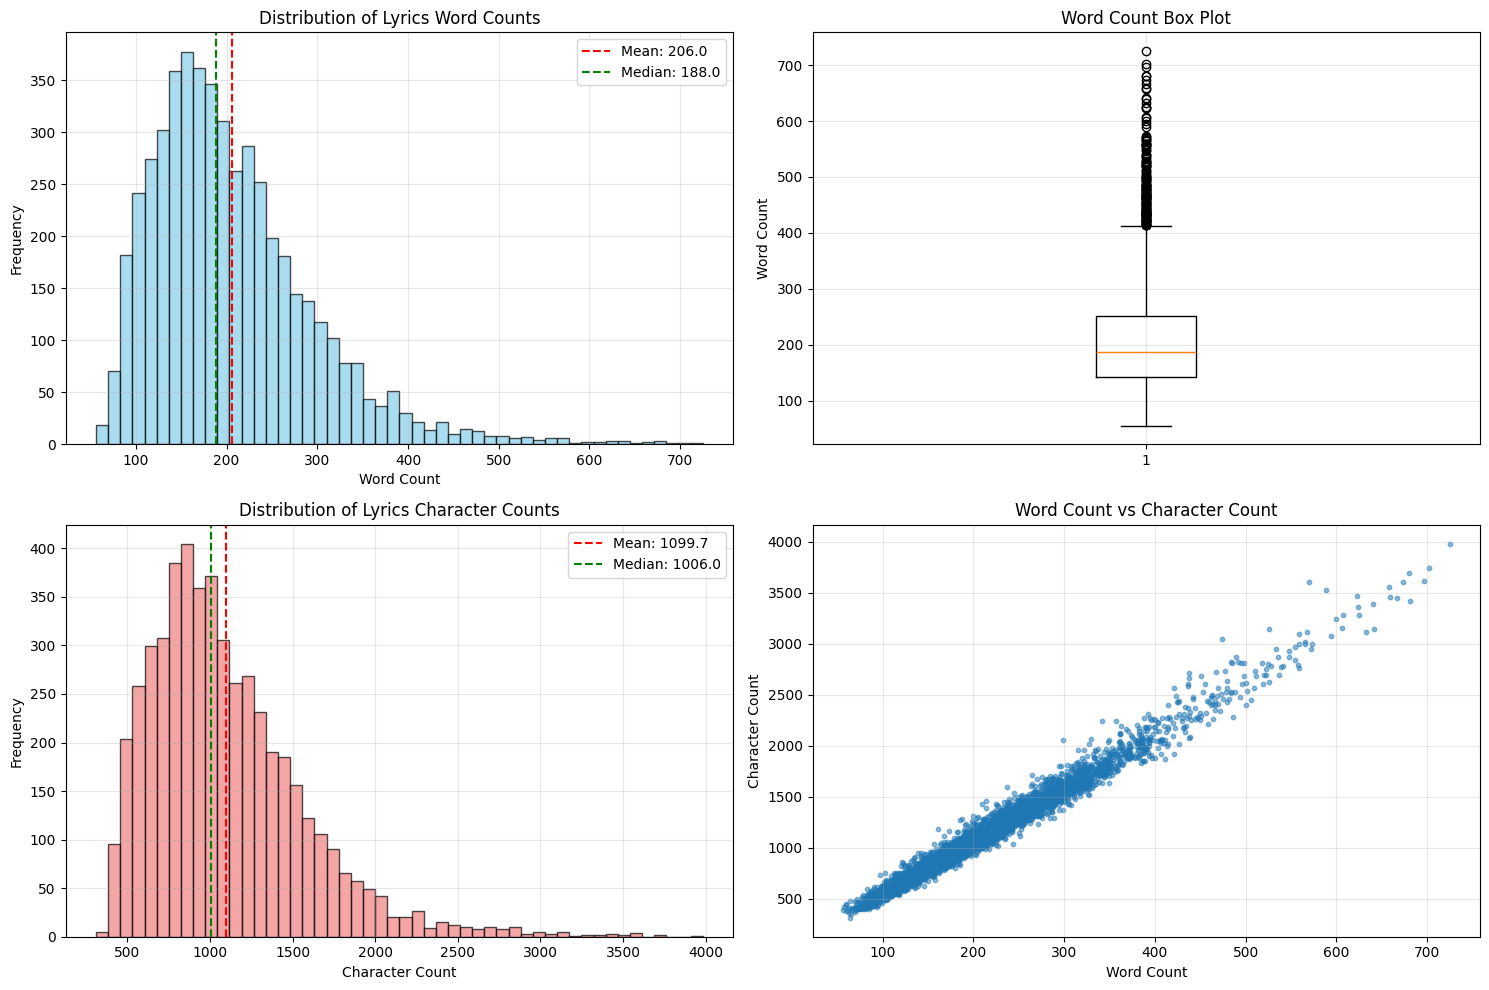


Length Distribution Statistics

Word Count Statistics:
  Mean:   206.00 words
  Median: 188.00 words
  Std:    89.61 words
  Min:    56 words
  Max:    725 words
  Q25:    143.00 words
  Q75:    251.00 words

Character Count Statistics:
  Mean:   1099.74 characters
  Median: 1006.00 characters
  Std:    472.92 characters
  Min:    311 characters
  Max:    3982 characters


In [18]:
# ============================================================================
# Length Distribution Analysis
# ============================================================================
def analyze_length_distribution(lyrics_list):
    """
    Analyze the distribution of song lengths (word counts and character counts)
    
    Args:
        lyrics_list: List of cleaned lyrics strings
    
    Returns:
        Dictionary with statistics and visualization
    """
    # Calculate word counts and character counts
    word_counts = [len(lyric.split()) for lyric in lyrics_list]
    char_counts = [len(lyric) for lyric in lyrics_list]
    
    # Statistics
    stats = {
        'word_count': {
            'mean': np.mean(word_counts),
            'median': np.median(word_counts),
            'std': np.std(word_counts),
            'min': np.min(word_counts),
            'max': np.max(word_counts),
            'q25': np.percentile(word_counts, 25),
            'q75': np.percentile(word_counts, 75)
        },
        'char_count': {
            'mean': np.mean(char_counts),
            'median': np.median(char_counts),
            'std': np.std(char_counts),
            'min': np.min(char_counts),
            'max': np.max(char_counts)
        }
    }
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Word count histogram
    axes[0, 0].hist(word_counts, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
    axes[0, 0].axvline(stats['word_count']['mean'], color='red', linestyle='--', 
                       label=f"Mean: {stats['word_count']['mean']:.1f}")
    axes[0, 0].axvline(stats['word_count']['median'], color='green', linestyle='--', 
                       label=f"Median: {stats['word_count']['median']:.1f}")
    axes[0, 0].set_xlabel('Word Count')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of Lyrics Word Counts')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Word count box plot
    axes[0, 1].boxplot(word_counts, vert=True)
    axes[0, 1].set_ylabel('Word Count')
    axes[0, 1].set_title('Word Count Box Plot')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Character count histogram
    axes[1, 0].hist(char_counts, bins=50, edgecolor='black', alpha=0.7, color='lightcoral')
    axes[1, 0].axvline(stats['char_count']['mean'], color='red', linestyle='--', 
                       label=f"Mean: {stats['char_count']['mean']:.1f}")
    axes[1, 0].axvline(stats['char_count']['median'], color='green', linestyle='--', 
                       label=f"Median: {stats['char_count']['median']:.1f}")
    axes[1, 0].set_xlabel('Character Count')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Distribution of Lyrics Character Counts')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Word vs Character count scatter
    axes[1, 1].scatter(word_counts, char_counts, alpha=0.5, s=10)
    axes[1, 1].set_xlabel('Word Count')
    axes[1, 1].set_ylabel('Character Count')
    axes[1, 1].set_title('Word Count vs Character Count')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Ensure output directory exists
    os.makedirs('../output', exist_ok=True)
    
    plt.tight_layout()
    plt.savefig('../output/lyrics_length_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print statistics
    print("\n" + "=" * 80)
    print("Length Distribution Statistics")
    print("=" * 80)
    print("\nWord Count Statistics:")
    print(f"  Mean:   {stats['word_count']['mean']:.2f} words")
    print(f"  Median: {stats['word_count']['median']:.2f} words")
    print(f"  Std:    {stats['word_count']['std']:.2f} words")
    print(f"  Min:    {stats['word_count']['min']} words")
    print(f"  Max:    {stats['word_count']['max']} words")
    print(f"  Q25:    {stats['word_count']['q25']:.2f} words")
    print(f"  Q75:    {stats['word_count']['q75']:.2f} words")
    
    print("\nCharacter Count Statistics:")
    print(f"  Mean:   {stats['char_count']['mean']:.2f} characters")
    print(f"  Median: {stats['char_count']['median']:.2f} characters")
    print(f"  Std:    {stats['char_count']['std']:.2f} characters")
    print(f"  Min:    {stats['char_count']['min']} characters")
    print(f"  Max:    {stats['char_count']['max']} characters")
    print("=" * 80)
    
    return stats, word_counts, char_counts

# Execute analysis
length_stats, word_counts, char_counts = analyze_length_distribution(cleaned_lyrics)



Top 50 Most Frequent Words
  1. your                 :   9410 occurrences
  2. love                 :   8325 occurrences
  3. all                  :   8171 occurrences
  4. dont                 :   6480 occurrences
  5. just                 :   5946 occurrences
  6. its                  :   5919 occurrences
  7. know                 :   5835 occurrences
  8. when                 :   5273 occurrences
  9. like                 :   5062 occurrences
 10. what                 :   4404 occurrences
 11. got                  :   4254 occurrences
 12. now                  :   4215 occurrences
 13. youre                :   3844 occurrences
 14. down                 :   3671 occurrences
 15. time                 :   3649 occurrences
 16. one                  :   3487 occurrences
 17. out                  :   3413 occurrences
 18. baby                 :   3358 occurrences
 19. get                  :   3306 occurrences
 20. want                 :   3250 occurrences
 21. never                :   32

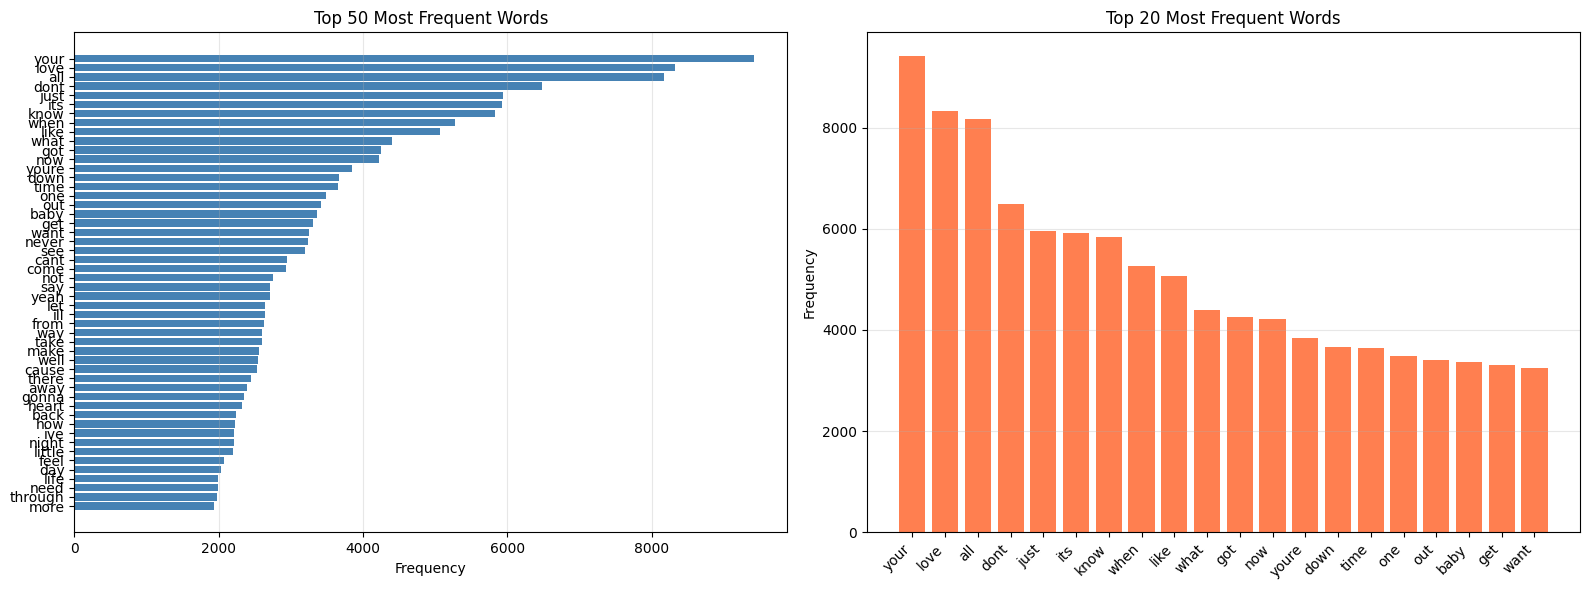

In [19]:
# ============================================================================
# Word Frequency Analysis
# ============================================================================
def analyze_word_frequency(lyrics_list, top_n=50):
    """
    Analyze word frequency in the lyrics dataset
    
    Args:
        lyrics_list: List of cleaned lyrics strings
        top_n: Number of top words to display
    
    Returns:
        Counter object with word frequencies
    """
    # Combine all lyrics into a single text
    all_text = ' '.join(lyrics_list).lower()
    
    # Remove punctuation and split into words
    import string
    # Remove punctuation
    translator = str.maketrans('', '', string.punctuation)
    all_text = all_text.translate(translator)
    
    # Split into words
    words = all_text.split()
    
    # Filter out very short words (1-2 characters) and common stop words
    stop_words = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 
                  'of', 'with', 'by', 'is', 'are', 'was', 'were', 'be', 'been', 'being',
                  'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'could',
                  'should', 'may', 'might', 'must', 'can', 'this', 'that', 'these', 'those',
                  'i', 'you', 'he', 'she', 'it', 'we', 'they', 'me', 'him', 'her', 'us', 'them'}
    
    # Filter words
    filtered_words = [w for w in words if len(w) > 2 and w not in stop_words]
    
    # Count word frequencies
    word_freq = Counter(filtered_words)
    
    # Get top N words
    top_words = word_freq.most_common(top_n)
    
    # Print top words
    print("\n" + "=" * 80)
    print(f"Top {top_n} Most Frequent Words")
    print("=" * 80)
    for i, (word, count) in enumerate(top_words, 1):
        print(f"{i:3d}. {word:20s} : {count:6d} occurrences")
    print("=" * 80)
    
    # Create visualization
    words_list, counts_list = zip(*top_words)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Horizontal bar chart
    y_pos = np.arange(len(words_list))
    axes[0].barh(y_pos, counts_list, color='steelblue')
    axes[0].set_yticks(y_pos)
    axes[0].set_yticklabels(words_list)
    axes[0].invert_yaxis()
    axes[0].set_xlabel('Frequency')
    axes[0].set_title(f'Top {top_n} Most Frequent Words')
    axes[0].grid(True, alpha=0.3, axis='x')
    
    # Top 20 words bar chart (vertical)
    top_20_words = top_words[:20]
    words_20, counts_20 = zip(*top_20_words)
    axes[1].bar(range(len(words_20)), counts_20, color='coral')
    axes[1].set_xticks(range(len(words_20)))
    axes[1].set_xticklabels(words_20, rotation=45, ha='right')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Top 20 Most Frequent Words')
    axes[1].grid(True, alpha=0.3, axis='y')
    
    # Ensure output directory exists
    os.makedirs('../output', exist_ok=True)
    
    plt.tight_layout()
    plt.savefig('../output/word_frequency_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    return word_freq, top_words

# Execute word frequency analysis
word_frequency, top_words = analyze_word_frequency(cleaned_lyrics, top_n=50)


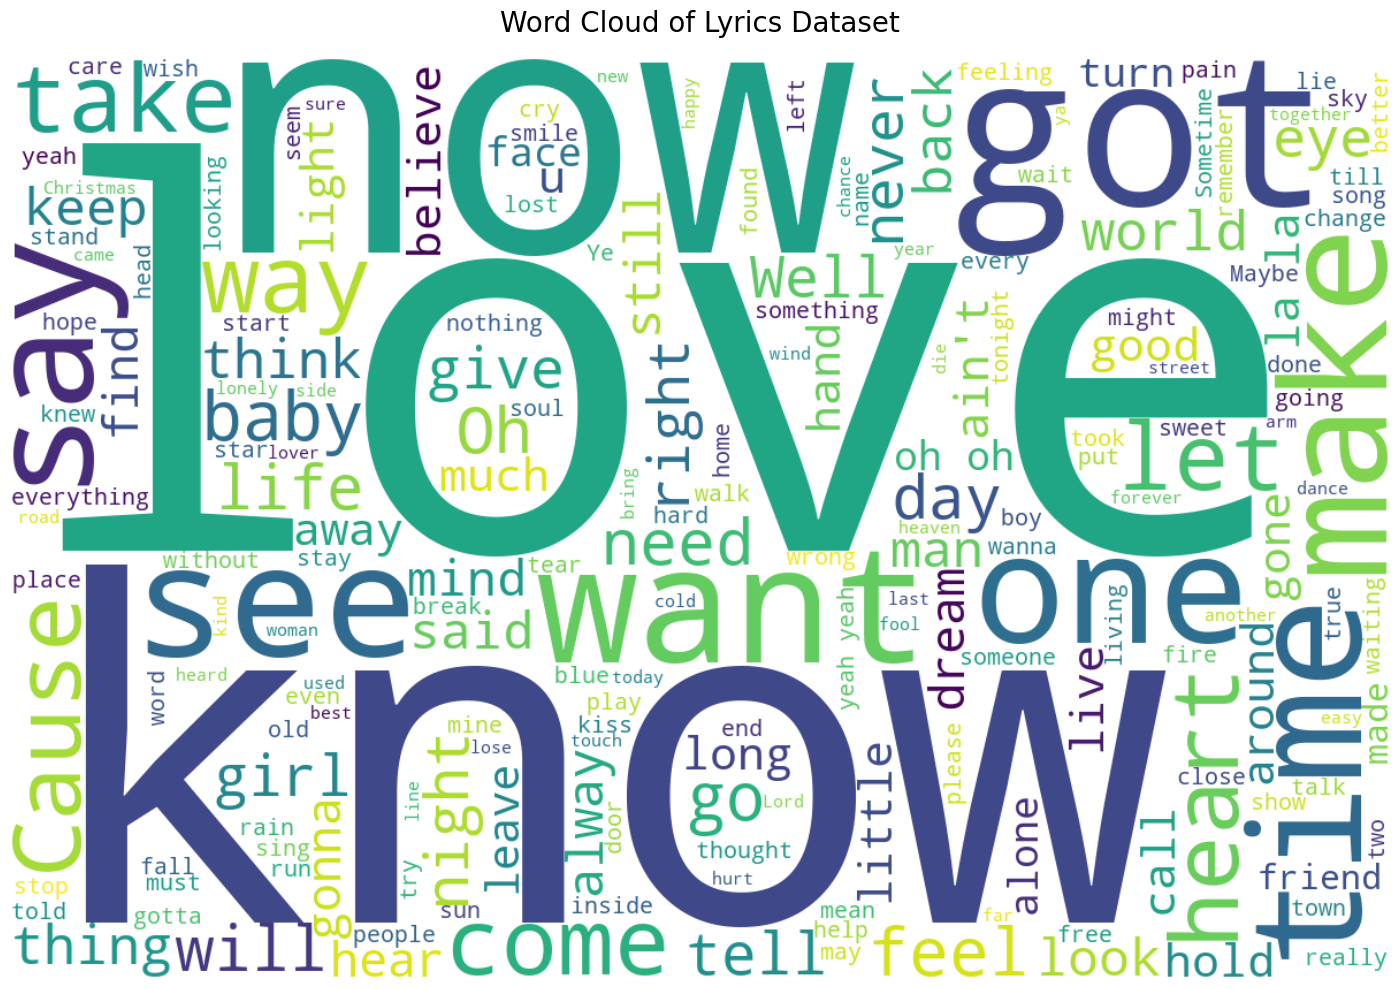

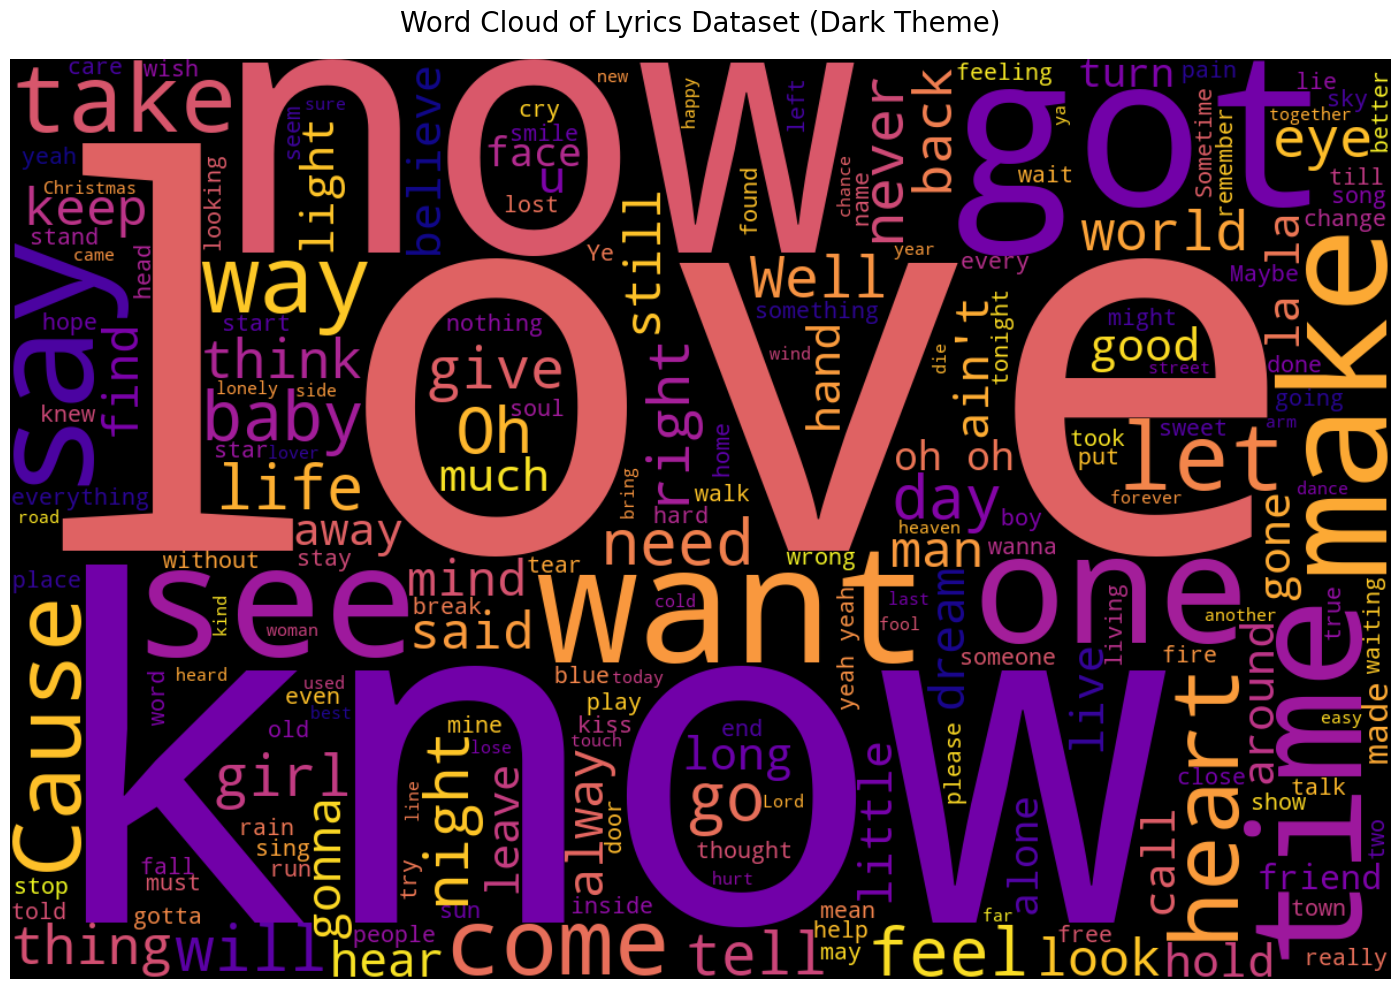


✓ Word clouds generated and saved


In [20]:
# ============================================================================
# Word Cloud Generation
# ============================================================================
def generate_word_cloud(lyrics_list, max_words=200):
    """
    Generate word cloud visualization from lyrics dataset
    
    Args:
        lyrics_list: List of cleaned lyrics strings
        max_words: Maximum number of words to include in word cloud
    
    Returns:
        WordCloud object
    """
    # Combine all lyrics
    all_text = ' '.join(lyrics_list)
    
    # Create word cloud
    wordcloud = WordCloud(
        width=1200,
        height=800,
        background_color='white',
        max_words=max_words,
        colormap='viridis',
        relative_scaling=0.5,
        random_state=42
    ).generate(all_text)
    
    # Ensure output directory exists
    os.makedirs('../output', exist_ok=True)
    
    # Display word cloud
    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Lyrics Dataset', fontsize=20, pad=20)
    plt.tight_layout()
    plt.savefig('../output/lyrics_wordcloud.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Generate a second word cloud with different style
    wordcloud2 = WordCloud(
        width=1200,
        height=800,
        background_color='black',
        max_words=max_words,
        colormap='plasma',
        relative_scaling=0.5,
        random_state=42
    ).generate(all_text)
    
    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud2, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Lyrics Dataset (Dark Theme)', fontsize=20, pad=20)
    plt.tight_layout()
    plt.savefig('../output/lyrics_wordcloud_dark.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n✓ Word clouds generated and saved")
    return wordcloud

# Generate word clouds
wordcloud = generate_word_cloud(cleaned_lyrics, max_words=200)


---

## 4. GPT-2 Model Loading

- Loads the base `GPT2LMHeadModel` and `GPT2Tokenizer` (either `gpt2` or a checkpoint path defined in the config cell).
- Applies tokenizer tweaks (pad token assignment, truncation rules) to avoid tensor shape mismatches.
- Reports parameter counts and memory footprint so GPU requirements are clear before training.


In [21]:
# ============================================================================
# Load GPT-2 Model and Tokenizer
# ============================================================================
print(f"Loading GPT-2 model: {CONFIG['model_name']}...")

# Load Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained(
    CONFIG['model_name'],
    cache_dir=CONFIG['cache_dir']
)

# Set special tokens
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'left'  # GPT-2 uses left padding

print(f"✓ Tokenizer loaded")
print(f"  Vocabulary size: {len(tokenizer):,}")
print(f"  Special tokens:")
print(f"    BOS: {tokenizer.bos_token} (ID: {tokenizer.bos_token_id})")
print(f"    EOS: {tokenizer.eos_token} (ID: {tokenizer.eos_token_id})")
print(f"    PAD: {tokenizer.pad_token} (ID: {tokenizer.pad_token_id})")

# Load Model
model = GPT2LMHeadModel.from_pretrained(
    CONFIG['model_name'],
    cache_dir=CONFIG['cache_dir']
)
model.to(DEVICE)
model.eval()

print(f"\n✓ Model loaded")
total_params = sum(p.numel() for p in model.parameters())
print(f"  Total parameters: {total_params:,}")
print(f"  Model size: ~{total_params * 4 / 1e6:.1f} MB (FP32)")

Loading GPT-2 model: gpt2...
✓ Tokenizer loaded
  Vocabulary size: 50,257
  Special tokens:
    BOS: <|endoftext|> (ID: 50256)
    EOS: <|endoftext|> (ID: 50256)
    PAD: <|endoftext|> (ID: 50256)


Loading weights: 100%|██████████| 148/148 [00:00<00:00, 574.26it/s, Materializing param=transformer.wte.weight]             
GPT2LMHeadModel LOAD REPORT from: gpt2
Key                  | Status     |  | 
---------------------+------------+--+-
h.{0...11}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



✓ Model loaded
  Total parameters: 124,439,808
  Model size: ~497.8 MB (FP32)


---

## 5. Model Fine-tuning

- Builds a `TextDataset` or `datasets` pipeline with `DataCollatorForLanguageModeling`.
- Configures `TrainingArguments` (epochs, batch size, gradient accumulation, learning rate schedule, logging) tailored to lyrics corpora.
- Enables advanced options such as mixed precision, gradient checkpointing, and periodic checkpoint exports under `models/gpt2_lyrics/`.

Fine-tuning is optional if zero-shot generation with the base checkpoint suffices.


In [22]:
# ============================================================================
# Prepare Training Dataset
# ============================================================================
if CONFIG['do_fine_tune']:
    class LyricsDataset(Dataset):
        """Lyrics dataset for GPT-2 fine-tuning"""
        
        def __init__(self, lyrics, tokenizer, max_length=512):
            self.tokenizer = tokenizer
            self.max_length = max_length
            self.encodings = []
            
            print(f"Encoding {len(lyrics)} lyrics...")
            for lyric in tqdm(lyrics):
                # Add structured format
                formatted_text = f"{lyric}{tokenizer.eos_token}"
                
                # Encode
                encoding = tokenizer(
                    formatted_text,
                    max_length=max_length,
                    truncation=True,
                    padding=False,
                    return_tensors=None
                )
                
                self.encodings.append(encoding['input_ids'])
            
            print(f"✓ Encoding complete, total {len(self.encodings)} sequences")
        
        def __len__(self):
            return len(self.encodings)
        
        def __getitem__(self, idx):
            return {'input_ids': torch.tensor(self.encodings[idx])}
    
    # Split dataset
    split_idx = int(len(cleaned_lyrics) * CONFIG['train_split'])
    train_lyrics = cleaned_lyrics[:split_idx]
    val_lyrics = cleaned_lyrics[split_idx:]
    
    print(f"\nDataset Split:")
    print(f"  Training set: {len(train_lyrics):,}")
    print(f"  Validation set: {len(val_lyrics):,}")
    
    # Create datasets
    train_dataset = LyricsDataset(train_lyrics, tokenizer, CONFIG['max_length'])
    val_dataset = LyricsDataset(val_lyrics, tokenizer, CONFIG['max_length'])
    
else:
    print("Skipping fine-tuning (CONFIG['do_fine_tune'] = False)")
    print("Using pre-trained GPT-2 model directly")


Dataset Split:
  Training set: 4,500
  Validation set: 500
Encoding 4500 lyrics...


100%|██████████| 4500/4500 [00:07<00:00, 640.64it/s]


✓ Encoding complete, total 4500 sequences
Encoding 500 lyrics...


100%|██████████| 500/500 [00:00<00:00, 646.40it/s]

✓ Encoding complete, total 500 sequences


In [23]:
# ============================================================================
# Fine-tune Model
# ============================================================================
if CONFIG['do_fine_tune']:
    # Create output directory
    os.makedirs(CONFIG['output_dir'], exist_ok=True)
    
    # Training arguments
    training_args = TrainingArguments(
        output_dir=CONFIG['output_dir'],
        num_train_epochs=CONFIG['num_epochs'],
        per_device_train_batch_size=CONFIG['batch_size'],
        per_device_eval_batch_size=CONFIG['batch_size'],
        warmup_steps=CONFIG['warmup_steps'],
        learning_rate=CONFIG['learning_rate'],
        save_steps=CONFIG['save_steps'],
        save_total_limit=2,
        eval_strategy="steps",  # Updated from evaluation_strategy
        eval_steps=CONFIG['save_steps'],
        logging_steps=100,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        fp16=DEVICE.type == 'cuda',  # Use mixed precision training
        report_to="none",
    )
    
    # Data collator
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=False  # GPT-2 uses Causal Language Modeling, not MLM
    )
    
    # Create Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=data_collator,
    )
    
    print("\nStarting fine-tuning...")
    print("=" * 80)
    
    # Train
    trainer.train()
    
    print("\n✓ Fine-tuning completed")
    
    # Save final model
    final_model_path = os.path.join(CONFIG['output_dir'], 'final_model')
    trainer.save_model(final_model_path)
    tokenizer.save_pretrained(final_model_path)
    
    print(f"✓ Model saved to: {final_model_path}")
    
else:
    print("Skipping fine-tuning step")


Starting fine-tuning...


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss
1000,2.095300,2.186943
2000,2.012300,2.153712
3000,1.907500,2.145372


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].



✓ Fine-tuning completed
✓ Model saved to: ../models/gpt2_lyrics\final_model


In [24]:
# ============================================================================
# Calculate Perplexity (PPL)
# ============================================================================
import math

if CONFIG['do_fine_tune']:
    print("\nCalculating Perplexity...")
    
    # Evaluate on validation set
    eval_results = trainer.evaluate()
    
    # Calculate PPL = exp(CrossEntropyLoss)
    perplexity = math.exp(eval_results['eval_loss'])
    
    print(f"\n=== Quantitative Evaluation ===")
    print(f"Validation Loss: {eval_results['eval_loss']:.4f}")
    print(f"Perplexity (PPL): {perplexity:.4f}")
    
    # Log to file
    with open(os.path.join(CONFIG['output_dir'], 'eval_results.txt'), 'w') as f:
        f.write(f"Validation Loss: {eval_results['eval_loss']:.4f}\n")
        f.write(f"Perplexity: {perplexity:.4f}\n")


Calculating Perplexity...



=== Quantitative Evaluation ===
Validation Loss: 2.1454
Perplexity (PPL): 8.5452


---

## 5. Lyrics Generation and Testing

Defines `generate_lyrics(theme, mood, keywords, ...)` that:

1. Crafts a structured prompt combining user inputs.
2. Calls `model.generate` with tuned decoding settings (temperature, top-k or top-p, repetition penalty, maximum tokens).
3. Post-processes the raw output by deduplicating verses and fixing basic punctuation.

Example invocations demonstrate how decoding parameters shift creativity versus coherence.


In [25]:
# ============================================================================
# Lyrics Generation Function
# ============================================================================
def generate_lyrics(
    theme: str,
    mood: str,
    keywords: str = "",
    max_new_tokens: int = 300,
    min_new_tokens: int = 100,
    temperature: float = 0.9,
    top_k: int = 50,
    top_p: float = 0.95,
    repetition_penalty: float = 1.2,
) -> str:
    """
    Generate lyrics using GPT-2
    
    Args:
        theme: Song theme
        mood: Mood tone
        keywords: Keywords (optional)
        max_new_tokens: Maximum new tokens to generate
        min_new_tokens: Minimum new tokens to generate
        temperature: Temperature parameter
        top_k: Top-K sampling
        top_p: Top-P sampling
        repetition_penalty: Repetition penalty
    
    Returns:
        Generated lyrics
    """
    # Construct prompt
    prompt = f"Song Title: {theme.title()}\n"
    prompt += f"Mood: {mood.capitalize()}\n\n"
    
    if keywords:
        prompt += f"[Verse 1]\n{keywords.capitalize()}"
    else:
        prompt += f"[Verse 1]\n"
    
    # Encode input
    inputs = tokenizer(prompt, return_tensors='pt').to(DEVICE)
    
    # Generate
    with torch.no_grad():
        outputs = model.generate(
            inputs['input_ids'],
            max_new_tokens=max_new_tokens,
            min_new_tokens=min_new_tokens,
            temperature=temperature,
            top_k=top_k,
            top_p=top_p,
            repetition_penalty=repetition_penalty,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id,
            early_stopping=True,
            num_return_sequences=1,
        )
    
    # Decode
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Post-processing cleanup
    # Remove artifacts and non-standard characters
    generated_text = generated_text.encode('ascii', 'ignore').decode('ascii')
    generated_text = re.sub(r'externalToEVA', '', generated_text, flags=re.IGNORECASE)
    generated_text = re.sub(r'[^a-zA-Z0-9\s.,!?\'\"\-;:\n]', '', generated_text)
    
    # Clean output
    generated_text = generated_text.strip()
    
    return generated_text


print("✓ Generation function defined")

✓ Generation function defined


In [26]:
# ============================================================================
# Test Lyrics Generation
# ============================================================================
print("\n" + "=" * 80)
print("Lyrics Generation Test")
print("=" * 80)

# Test cases
test_cases = [
    {
        'theme': 'lost love',
        'mood': 'sad',
        'keywords': 'memories',
    },
    {
        'theme': 'summer night',
        'mood': 'happy',
        'keywords': 'dancing',
    },
    {
        'theme': 'hope',
        'mood': 'uplifting',
        'keywords': '',
    },
]

for i, test_case in enumerate(test_cases, 1):
    print(f"\n[Test {i}]")
    print(f"Theme: {test_case['theme']}")
    print(f"Mood: {test_case['mood']}")
    print(f"Keywords: {test_case['keywords'] or 'None'}")
    print("-" * 80)
    
    lyrics = generate_lyrics(
        theme=test_case['theme'],
        mood=test_case['mood'],
        keywords=test_case['keywords'],
        max_new_tokens=CONFIG['max_new_tokens'],
        temperature=CONFIG['temperature'],
        top_k=CONFIG['top_k'],
        top_p=CONFIG['top_p'],
        repetition_penalty=CONFIG['repetition_penalty'],
    )
    
    print(lyrics)
    print("=" * 80)

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



Lyrics Generation Test

[Test 1]
Theme: lost love
Mood: sad
Keywords: memories
--------------------------------------------------------------------------------
Song Title: Lost Love
Mood: Sad

Verse 1
Memories all around me 

 "Tired of being lost," my heart said.  I was with you, you were right here to stay for hours 
But now that the tears have dried off and we've both been left in this place again... Oh... 
Well come back on down my street and find out what it feels like 
We know our hearts are broken inside 
And nothing can ever change the fact there's so much pain 
When love has just passed away quickShip

[Test 2]
Theme: summer night
Mood: happy
Keywords: dancing
--------------------------------------------------------------------------------
Song Title: Summer Night
Mood: Happy

Verse 1
Dancing in the night 

A dancer in a pool of his own blood that's burning hot 
Someone you can't understand just what is happening here. 
Whoa, whoah baby 
They ran right by where our dreams en

---

## 6. Interactive Generation

Provides a lightweight CLI or widget loop to experiment with prompts in real time:

- Accepts theme, mood, and custom prefixes at runtime.
- Streams intermediate tokens when enabled through `transformers.GenerationConfig`.
- Logs prompts and outputs for qualitative review and UX tuning.

Use this section to curate demo lyrics before wiring the service into the frontend.


In [27]:
# ============================================================================
# Interactive Generation (Customizable Parameters)
# ============================================================================
def interactive_generation():
    """Interactive Lyrics Generation"""
    print("\n" + "=" * 80)
    print("Interactive Lyrics Generation")
    print("=" * 80)
    print("Tip: Leave empty to use default values, enter 'quit' to exit\n")
    
    while True:
        # Get input
        theme = input("Song Theme [love]: ").strip() or "love"
        if theme.lower() == 'quit':
            break
        
        mood = input("Mood Tone [happy]: ").strip() or "happy"
        keywords = input("Keywords [Optional]: ").strip()
        
        temp_input = input(f"Temperature [{CONFIG['temperature']}]: ").strip()
        temperature = float(temp_input) if temp_input else CONFIG['temperature']
        
        tokens_input = input(f"Max tokens [{CONFIG['max_new_tokens']}]: ").strip()
        max_tokens = int(tokens_input) if tokens_input else CONFIG['max_new_tokens']
        
        # Generate
        print("\nGenerating...")
        lyrics = generate_lyrics(
            theme=theme,
            mood=mood,
            keywords=keywords,
            max_new_tokens=max_tokens,
            temperature=temperature,
        )
        
        # Show results
        print("\n" + "=" * 80)
        print("Generated Lyrics:")
        print("=" * 80)
        print(lyrics)
        print("=" * 80 + "\n")
        
        # Continue?
        continue_gen = input("Continue generating? (y/n) [y]: ").strip().lower()
        if continue_gen == 'n':
            break
        print("\n")
    
    print("\nThank you for using!")


# Uncomment to run interactive generation
# interactive_generation()

---

## 7. Model Export and Backend Integration

- Saves tokenizer and model weights to `models/gpt2_lyrics/final_model`.
- Demonstrates optional conversion to `safetensors` or other deployment-friendly formats.
- Documents the interface expected by `backend/services/lyrics_service.py`, allowing the backend to swap checkpoints without code changes.


In [28]:
# ============================================================================
# Export Model for Backend Service
# ============================================================================
def export_model_for_backend():
    """Export model to a format usable by the backend"""
    export_path = '../models/gpt2_lyrics_backend'
    os.makedirs(export_path, exist_ok=True)
    
    print(f"Exporting model to: {export_path}")
    
    # Save model and tokenizer
    # Note: safe_serialization=False is used to avoid Windows OS Error 1224 (file mapping conflict)
    # This saves as pytorch_model.bin instead of model.safetensors
    try:
        model.save_pretrained(export_path, safe_serialization=False)
    except Exception as e:
        print(f"Warning: Standard save failed, trying with safe_serialization=True: {e}")
        model.save_pretrained(export_path, safe_serialization=True)
        
    tokenizer.save_pretrained(export_path)
    
    # Save configuration info
    config_info = {
        'model_type': 'gpt2',
        'model_name': CONFIG['model_name'],
        'vocab_size': len(tokenizer),
        'max_length': CONFIG['max_length'],
        'default_params': {
            'temperature': CONFIG['temperature'],
            'top_k': CONFIG['top_k'],
            'top_p': CONFIG['top_p'],
            'repetition_penalty': CONFIG['repetition_penalty'],
            'max_new_tokens': CONFIG['max_new_tokens'],
        },
        'fine_tuned': CONFIG['do_fine_tune'],
    }
    
    config_file = os.path.join(export_path, 'backend_config.json')
    with open(config_file, 'w', encoding='utf-8') as f:
        json.dump(config_info, f, indent=2, ensure_ascii=False)

    return export_path


# Execute export
export_path = export_model_for_backend()
print(f"\n✓ Export complete: {export_path}")

Exporting model to: ../models/gpt2_lyrics_backend

✓ Export complete: ../models/gpt2_lyrics_backend


---

## 8. Performance Evaluation

- Logs quantitative metrics such as validation loss and perplexity during training.
- Provides hooks for qualitative scoring (rhyme density, vocabulary diversity, manual rubric tables).
- Summarizes resource usage (training time, GPU type, VRAM) to aid reproducibility and capacity planning.

Update this section whenever a new checkpoint is promoted so stakeholders know which model powers production.


In [29]:
# ============================================================================
# Performance Test
# ============================================================================
import time

def benchmark_generation(num_samples=10):
    """Performance Benchmark"""
    print("\nPerformance Benchmark")
    print("=" * 80)
    
    themes = ['love', 'hope', 'dreams', 'freedom', 'journey']
    moods = ['happy', 'sad', 'energetic', 'calm', 'romantic']
    
    times = []
    token_counts = []
    
    for i in range(num_samples):
        theme = random.choice(themes)
        mood = random.choice(moods)
        
        start_time = time.time()
        lyrics = generate_lyrics(
            theme=theme,
            mood=mood,
            max_new_tokens=CONFIG['max_new_tokens']
        )
        end_time = time.time()
        
        elapsed = end_time - start_time
        num_tokens = len(tokenizer.encode(lyrics))
        
        times.append(elapsed)
        token_counts.append(num_tokens)
        
        print(f"  Sample {i+1}/{num_samples}: {elapsed:.2f}s, {num_tokens} tokens")
    
    # Statistics
    avg_time = np.mean(times)
    avg_tokens = np.mean(token_counts)
    tokens_per_sec = avg_tokens / avg_time
    
    print("\n" + "=" * 80)
    print("Performance Statistics:")
    print(f"  Average generation time: {avg_time:.2f}s")
    print(f"  Average token count: {avg_tokens:.1f}")
    print(f"  Generation speed: {tokens_per_sec:.1f} tokens/s")
    print("=" * 80)


# Run benchmark (optional)
benchmark_generation(num_samples=5)


Performance Benchmark
  Sample 1/5: 3.22s, 178 tokens
  Sample 2/5: 2.73s, 150 tokens
  Sample 3/5: 4.32s, 217 tokens
  Sample 4/5: 7.31s, 361 tokens
  Sample 5/5: 2.33s, 121 tokens

Performance Statistics:
  Average generation time: 3.98s
  Average token count: 205.4
  Generation speed: 51.6 tokens/s
